Original at: https://www.kaggle.com/c0conuts/unet-imagedatagenerator-lb-0-336/comments#latest-277820


# This notebook is a duplicate of Kjetil Åmdal-Sævik's "Keras U-Net starter - LB 0.277" to which I added Data Augmentation using keras ImageDataGenerator.


### Importing the needed libraries

In [2]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Set some parameters
BATCH_SIZE = 10 # the higher the better
IMG_WIDTH = 256 # for faster computing on kaggle
IMG_HEIGHT = 256 # for faster computing on kaggle
IMG_CHANNELS = 3
TRAIN_PATH = '../input/stage1_train/'
TEST_PATH = '../input/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42

###  1. Preparing the data

In [3]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]
np.random.seed(10)

In [4]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [04:34<00:00,  3.58it/s]


Getting and resizing test images ... 


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 12.30it/s]


Done!


###  2. Data Augmentation

In [5]:
from keras.preprocessing import image

# Creating the training Image and Mask generator
image_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
mask_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')

# Keep the same seed for image and mask generators so they fit together

image_datagen.fit(X_train[:int(X_train.shape[0]*0.9)], augment=True, seed=seed)
mask_datagen.fit(Y_train[:int(Y_train.shape[0]*0.9)], augment=True, seed=seed)

x=image_datagen.flow(X_train[:int(X_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y=mask_datagen.flow(Y_train[:int(Y_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)



# Creating the validation Image and Mask generator
image_datagen_val = image.ImageDataGenerator()
mask_datagen_val = image.ImageDataGenerator()

image_datagen_val.fit(X_train[int(X_train.shape[0]*0.9):], augment=True, seed=seed)
mask_datagen_val.fit(Y_train[int(Y_train.shape[0]*0.9):], augment=True, seed=seed)

x_val=image_datagen_val.flow(X_train[int(X_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y_val=mask_datagen_val.flow(Y_train[int(Y_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)

c:\users\peter\anaconda3\envs\tflearn-gpu\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (603, 256, 256, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')
c:\users\peter\anaconda3\envs\tflearn-gpu\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (67, 256, 256, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


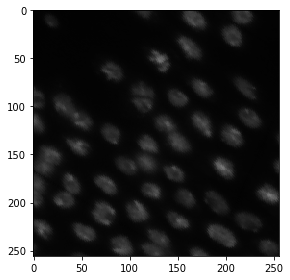

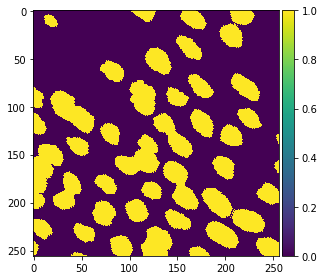

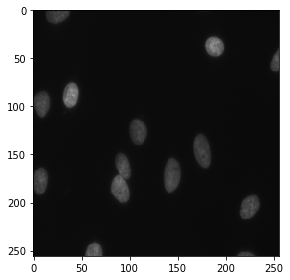

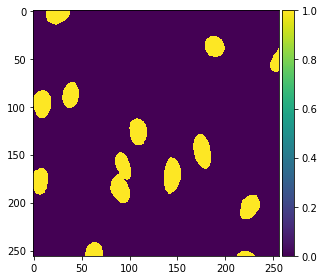

In [6]:
# Checking if the images fit

from matplotlib import pyplot as plt
%matplotlib inline

imshow(x.next()[0].astype(np.uint8))
plt.show()
imshow(np.squeeze(y.next()[0].astype(np.uint8)))
plt.show()
imshow(x_val.next()[0].astype(np.uint8))
plt.show()
imshow(np.squeeze(y_val.next()[0].astype(np.uint8)))
plt.show()

In [7]:
#creating a training and validation generator that generate masks and images
train_generator = zip(x, y)
val_generator = zip(x_val, y_val)

###  3. Creating the U-net model

In [8]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [9]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 256, 256, 3)   0           input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 256, 256, 16)  448         lambda_1[0][0]                   
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 256, 256, 16)  0           conv2d_1[0][0]                   
___________________________________________________________________________________________

                                                                   conv2d_2[0][0]                   
____________________________________________________________________________________________________
conv2d_17 (Conv2D)               (None, 256, 256, 16)  4624        concatenate_4[0][0]              
____________________________________________________________________________________________________
dropout_9 (Dropout)              (None, 256, 256, 16)  0           conv2d_17[0][0]                  
____________________________________________________________________________________________________
conv2d_18 (Conv2D)               (None, 256, 256, 16)  2320        dropout_9[0][0]                  
____________________________________________________________________________________________________
conv2d_19 (Conv2D)               (None, 256, 256, 1)   17          conv2d_18[0][0]                  
Total params: 1,941,105
Trainable params: 1,941,105
Non-trainable params: 0
_______________

###  4. Training

In [10]:
# Fit model
earlystopper = EarlyStopping(patience=3, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit_generator(train_generator, validation_data=val_generator, validation_steps=10, steps_per_epoch=250,
                              epochs=3, callbacks=[earlystopper, checkpointer])

Epoch 1/3


185/250 [=====================>........] - ETA: 4891s - loss: 0.6481 - mean_iou: 0.0000e+0 - ETA: 2725s - loss: 0.6664 - mean_iou: 0.2157    - ETA: 1998s - loss: 0.6192 - mean_iou: 0.283 - ETA: 1635s - loss: 0.5690 - mean_iou: 0.317 - ETA: 1417s - loss: 0.5461 - mean_iou: 0.340 - ETA: 1269s - loss: 0.5257 - mean_iou: 0.354 - ETA: 1164s - loss: 0.5312 - mean_iou: 0.365 - ETA: 1083s - loss: 0.5103 - mean_iou: 0.372 - ETA: 1021s - loss: 0.5014 - mean_iou: 0.378 - ETA: 970s - loss: 0.5006 - mean_iou: 0.382 - ETA: 928s - loss: 0.4892 - mean_iou: 0.38 - ETA: 892s - loss: 0.4871 - mean_iou: 0.38 - ETA: 863s - loss: 0.4812 - mean_iou: 0.39 - ETA: 837s - loss: 0.4687 - mean_iou: 0.39 - ETA: 814s - loss: 0.4597 - mean_iou: 0.39 - ETA: 794s - loss: 0.4446 - mean_iou: 0.39 - ETA: 776s - loss: 0.4361 - mean_iou: 0.39 - ETA: 759s - loss: 0.4262 - mean_iou: 0.40 - ETA: 745s - loss: 0.4174 - mean_iou: 0.40 - ETA: 732s - loss: 0.4102 - mean_iou: 0.40 - ETA: 721s - loss: 0.4019 - mean_iou: 0.40 - ETA: 7

250/250 [==============================] - 619s - loss: 0.1659 - mean_iou: 0.6189 - val_loss: 0.1265 - val_mean_iou: 0.7207
Epoch 2/3


186/250 [=====================>........] - ETA: 573s - loss: 0.1818 - mean_iou: 0.72 - ETA: 571s - loss: 0.1585 - mean_iou: 0.72 - ETA: 573s - loss: 0.1386 - mean_iou: 0.72 - ETA: 573s - loss: 0.1258 - mean_iou: 0.72 - ETA: 570s - loss: 0.1187 - mean_iou: 0.72 - ETA: 567s - loss: 0.1171 - mean_iou: 0.72 - ETA: 565s - loss: 0.1208 - mean_iou: 0.72 - ETA: 561s - loss: 0.1150 - mean_iou: 0.72 - ETA: 560s - loss: 0.1147 - mean_iou: 0.72 - ETA: 557s - loss: 0.1120 - mean_iou: 0.72 - ETA: 556s - loss: 0.1088 - mean_iou: 0.72 - ETA: 553s - loss: 0.1133 - mean_iou: 0.72 - ETA: 552s - loss: 0.1115 - mean_iou: 0.72 - ETA: 549s - loss: 0.1155 - mean_iou: 0.72 - ETA: 547s - loss: 0.1167 - mean_iou: 0.72 - ETA: 544s - loss: 0.1160 - mean_iou: 0.72 - ETA: 541s - loss: 0.1158 - mean_iou: 0.72 - ETA: 539s - loss: 0.1143 - mean_iou: 0.72 - ETA: 538s - loss: 0.1108 - mean_iou: 0.72 - ETA: 536s - loss: 0.1136 - mean_iou: 0.72 - ETA: 534s - loss: 0.1124 - mean_iou: 0.72 - ETA: 533s - loss: 0.1141 - mean_i

250/250 [==============================] - 589s - loss: 0.0993 - mean_iou: 0.7514 - val_loss: 0.0854 - val_mean_iou: 0.7736
Epoch 3/3


186/250 [=====================>........] - ETA: 561s - loss: 0.0798 - mean_iou: 0.77 - ETA: 570s - loss: 0.0896 - mean_iou: 0.77 - ETA: 570s - loss: 0.0960 - mean_iou: 0.77 - ETA: 568s - loss: 0.1041 - mean_iou: 0.77 - ETA: 566s - loss: 0.1028 - mean_iou: 0.77 - ETA: 563s - loss: 0.1090 - mean_iou: 0.77 - ETA: 561s - loss: 0.0979 - mean_iou: 0.77 - ETA: 559s - loss: 0.0915 - mean_iou: 0.77 - ETA: 557s - loss: 0.0908 - mean_iou: 0.77 - ETA: 555s - loss: 0.0926 - mean_iou: 0.77 - ETA: 552s - loss: 0.0886 - mean_iou: 0.77 - ETA: 551s - loss: 0.0884 - mean_iou: 0.77 - ETA: 548s - loss: 0.0927 - mean_iou: 0.77 - ETA: 546s - loss: 0.0959 - mean_iou: 0.77 - ETA: 545s - loss: 0.0920 - mean_iou: 0.77 - ETA: 544s - loss: 0.0927 - mean_iou: 0.77 - ETA: 543s - loss: 0.0910 - mean_iou: 0.77 - ETA: 542s - loss: 0.0916 - mean_iou: 0.77 - ETA: 540s - loss: 0.0885 - mean_iou: 0.77 - ETA: 537s - loss: 0.0893 - mean_iou: 0.77 - ETA: 534s - loss: 0.0927 - mean_iou: 0.77 - ETA: 531s - loss: 0.0916 - mean_i

250/250 [==============================] - 584s - loss: 0.0895 - mean_iou: 0.7868 - val_loss: 0.0737 - val_mean_iou: 0.7965


### 4.1 Train more!

In [17]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-2.h5', verbose=1, save_best_only=True)

model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})

results = model.fit_generator(train_generator, validation_data=val_generator, validation_steps=10, steps_per_epoch=250,
                              epochs=30, callbacks=[earlystopper, checkpointer])

Epoch 1/30


185/250 [=====================>........] - ETA: 718s - loss: 0.1031 - mean_iou: 0.0000e+ - ETA: 643s - loss: 0.0756 - mean_iou: 0.4018   - ETA: 616s - loss: 0.0770 - mean_iou: 0.54 - ETA: 604s - loss: 0.0795 - mean_iou: 0.62 - ETA: 592s - loss: 0.0761 - mean_iou: 0.66 - ETA: 583s - loss: 0.0779 - mean_iou: 0.69 - ETA: 579s - loss: 0.0765 - mean_iou: 0.72 - ETA: 574s - loss: 0.0769 - mean_iou: 0.73 - ETA: 569s - loss: 0.0751 - mean_iou: 0.75 - ETA: 568s - loss: 0.0727 - mean_iou: 0.76 - ETA: 566s - loss: 0.0739 - mean_iou: 0.77 - ETA: 563s - loss: 0.0750 - mean_iou: 0.78 - ETA: 560s - loss: 0.0745 - mean_iou: 0.78 - ETA: 559s - loss: 0.0806 - mean_iou: 0.79 - ETA: 557s - loss: 0.0789 - mean_iou: 0.79 - ETA: 554s - loss: 0.0773 - mean_iou: 0.80 - ETA: 551s - loss: 0.0765 - mean_iou: 0.80 - ETA: 548s - loss: 0.0767 - mean_iou: 0.80 - ETA: 545s - loss: 0.0765 - mean_iou: 0.80 - ETA: 544s - loss: 0.0765 - mean_iou: 0.81 - ETA: 541s - loss: 0.0777 - mean_iou: 0.81 - ETA: 538s - loss: 0.0760 

250/250 [==============================] - 588s - loss: 0.0827 - mean_iou: 0.8437 - val_loss: 0.0779 - val_mean_iou: 0.8494
Epoch 2/30


186/250 [=====================>........] - ETA: 563s - loss: 0.1394 - mean_iou: 0.84 - ETA: 569s - loss: 0.1107 - mean_iou: 0.84 - ETA: 570s - loss: 0.1068 - mean_iou: 0.84 - ETA: 569s - loss: 0.0990 - mean_iou: 0.84 - ETA: 567s - loss: 0.0984 - mean_iou: 0.84 - ETA: 566s - loss: 0.0976 - mean_iou: 0.84 - ETA: 563s - loss: 0.0912 - mean_iou: 0.84 - ETA: 560s - loss: 0.0919 - mean_iou: 0.84 - ETA: 560s - loss: 0.0900 - mean_iou: 0.84 - ETA: 559s - loss: 0.0932 - mean_iou: 0.84 - ETA: 558s - loss: 0.0880 - mean_iou: 0.84 - ETA: 555s - loss: 0.0882 - mean_iou: 0.84 - ETA: 552s - loss: 0.0850 - mean_iou: 0.84 - ETA: 550s - loss: 0.0824 - mean_iou: 0.84 - ETA: 548s - loss: 0.0824 - mean_iou: 0.84 - ETA: 547s - loss: 0.0823 - mean_iou: 0.84 - ETA: 544s - loss: 0.0809 - mean_iou: 0.84 - ETA: 541s - loss: 0.0796 - mean_iou: 0.84 - ETA: 539s - loss: 0.0789 - mean_iou: 0.84 - ETA: 537s - loss: 0.0793 - mean_iou: 0.84 - ETA: 534s - loss: 0.0786 - mean_iou: 0.84 - ETA: 532s - loss: 0.0784 - mean_i

250/250 [==============================] - 586s - loss: 0.0789 - mean_iou: 0.8501 - val_loss: 0.0754 - val_mean_iou: 0.8510
Epoch 3/30


186/250 [=====================>........] - ETA: 571s - loss: 0.0576 - mean_iou: 0.85 - ETA: 572s - loss: 0.0610 - mean_iou: 0.85 - ETA: 569s - loss: 0.0578 - mean_iou: 0.85 - ETA: 564s - loss: 0.0646 - mean_iou: 0.85 - ETA: 561s - loss: 0.0637 - mean_iou: 0.85 - ETA: 560s - loss: 0.0632 - mean_iou: 0.85 - ETA: 559s - loss: 0.0619 - mean_iou: 0.85 - ETA: 557s - loss: 0.0626 - mean_iou: 0.85 - ETA: 555s - loss: 0.0637 - mean_iou: 0.85 - ETA: 554s - loss: 0.0650 - mean_iou: 0.85 - ETA: 551s - loss: 0.0643 - mean_iou: 0.85 - ETA: 548s - loss: 0.0622 - mean_iou: 0.85 - ETA: 545s - loss: 0.0631 - mean_iou: 0.85 - ETA: 543s - loss: 0.0643 - mean_iou: 0.85 - ETA: 542s - loss: 0.0657 - mean_iou: 0.85 - ETA: 541s - loss: 0.0649 - mean_iou: 0.85 - ETA: 539s - loss: 0.0666 - mean_iou: 0.85 - ETA: 537s - loss: 0.0681 - mean_iou: 0.85 - ETA: 535s - loss: 0.0681 - mean_iou: 0.85 - ETA: 515s - loss: 0.0691 - mean_iou: 0.85 - ETA: 514s - loss: 0.0694 - mean_iou: 0.85 - ETA: 513s - loss: 0.0703 - mean_i

250/250 [==============================] - 587s - loss: 0.0747 - mean_iou: 0.8523 - val_loss: 0.0721 - val_mean_iou: 0.8534
Epoch 4/30


186/250 [=====================>........] - ETA: 572s - loss: 0.0796 - mean_iou: 0.85 - ETA: 576s - loss: 0.0654 - mean_iou: 0.85 - ETA: 570s - loss: 0.0627 - mean_iou: 0.85 - ETA: 568s - loss: 0.0650 - mean_iou: 0.85 - ETA: 568s - loss: 0.0644 - mean_iou: 0.85 - ETA: 566s - loss: 0.0663 - mean_iou: 0.85 - ETA: 562s - loss: 0.0753 - mean_iou: 0.85 - ETA: 562s - loss: 0.0791 - mean_iou: 0.85 - ETA: 561s - loss: 0.0778 - mean_iou: 0.85 - ETA: 559s - loss: 0.0755 - mean_iou: 0.85 - ETA: 558s - loss: 0.0785 - mean_iou: 0.85 - ETA: 557s - loss: 0.0791 - mean_iou: 0.85 - ETA: 554s - loss: 0.0785 - mean_iou: 0.85 - ETA: 526s - loss: 0.0813 - mean_iou: 0.85 - ETA: 526s - loss: 0.0820 - mean_iou: 0.85 - ETA: 526s - loss: 0.0815 - mean_iou: 0.85 - ETA: 525s - loss: 0.0795 - mean_iou: 0.85 - ETA: 525s - loss: 0.0779 - mean_iou: 0.85 - ETA: 522s - loss: 0.0780 - mean_iou: 0.85 - ETA: 520s - loss: 0.0777 - mean_iou: 0.85 - ETA: 519s - loss: 0.0780 - mean_iou: 0.85 - ETA: 517s - loss: 0.0774 - mean_i

250/250 [==============================] - 585s - loss: 0.0750 - mean_iou: 0.8539 - val_loss: 0.0753 - val_mean_iou: 0.8544
Epoch 5/30


186/250 [=====================>........] - ETA: 568s - loss: 0.0650 - mean_iou: 0.85 - ETA: 568s - loss: 0.0730 - mean_iou: 0.85 - ETA: 566s - loss: 0.0616 - mean_iou: 0.85 - ETA: 565s - loss: 0.0662 - mean_iou: 0.85 - ETA: 567s - loss: 0.0627 - mean_iou: 0.85 - ETA: 568s - loss: 0.0723 - mean_iou: 0.85 - ETA: 567s - loss: 0.0719 - mean_iou: 0.85 - ETA: 519s - loss: 0.0732 - mean_iou: 0.85 - ETA: 522s - loss: 0.0719 - mean_iou: 0.85 - ETA: 522s - loss: 0.0716 - mean_iou: 0.85 - ETA: 525s - loss: 0.0746 - mean_iou: 0.85 - ETA: 525s - loss: 0.0766 - mean_iou: 0.85 - ETA: 524s - loss: 0.0823 - mean_iou: 0.85 - ETA: 524s - loss: 0.0815 - mean_iou: 0.85 - ETA: 523s - loss: 0.0828 - mean_iou: 0.85 - ETA: 523s - loss: 0.0855 - mean_iou: 0.85 - ETA: 522s - loss: 0.0867 - mean_iou: 0.85 - ETA: 521s - loss: 0.0853 - mean_iou: 0.85 - ETA: 520s - loss: 0.0866 - mean_iou: 0.85 - ETA: 518s - loss: 0.0871 - mean_iou: 0.85 - ETA: 518s - loss: 0.0864 - mean_iou: 0.85 - ETA: 517s - loss: 0.0862 - mean_i

250/250 [==============================] - 583s - loss: 0.0753 - mean_iou: 0.8546 - val_loss: 0.0657 - val_mean_iou: 0.8550
Epoch 6/30


186/250 [=====================>........] - ETA: 574s - loss: 0.0625 - mean_iou: 0.85 - ETA: 376s - loss: 0.0732 - mean_iou: 0.85 - ETA: 441s - loss: 0.0770 - mean_iou: 0.85 - ETA: 469s - loss: 0.0743 - mean_iou: 0.85 - ETA: 487s - loss: 0.0762 - mean_iou: 0.85 - ETA: 498s - loss: 0.0790 - mean_iou: 0.85 - ETA: 505s - loss: 0.0767 - mean_iou: 0.85 - ETA: 507s - loss: 0.0752 - mean_iou: 0.85 - ETA: 513s - loss: 0.0746 - mean_iou: 0.85 - ETA: 516s - loss: 0.0737 - mean_iou: 0.85 - ETA: 518s - loss: 0.0720 - mean_iou: 0.85 - ETA: 519s - loss: 0.0712 - mean_iou: 0.85 - ETA: 520s - loss: 0.0694 - mean_iou: 0.85 - ETA: 520s - loss: 0.0727 - mean_iou: 0.85 - ETA: 521s - loss: 0.0714 - mean_iou: 0.85 - ETA: 521s - loss: 0.0696 - mean_iou: 0.85 - ETA: 519s - loss: 0.0682 - mean_iou: 0.85 - ETA: 518s - loss: 0.0700 - mean_iou: 0.85 - ETA: 518s - loss: 0.0717 - mean_iou: 0.85 - ETA: 517s - loss: 0.0747 - mean_iou: 0.85 - ETA: 516s - loss: 0.0803 - mean_iou: 0.85 - ETA: 515s - loss: 0.0786 - mean_i

250/250 [==============================] - 582s - loss: 0.1468 - mean_iou: 0.8507 - val_loss: 0.1648 - val_mean_iou: 0.8382
Epoch 7/30


186/250 [=====================>........] - ETA: 565s - loss: 0.1110 - mean_iou: 0.83 - ETA: 571s - loss: 0.1613 - mean_iou: 0.83 - ETA: 569s - loss: 0.1541 - mean_iou: 0.83 - ETA: 564s - loss: 0.1443 - mean_iou: 0.83 - ETA: 563s - loss: 0.1805 - mean_iou: 0.83 - ETA: 562s - loss: 0.1830 - mean_iou: 0.83 - ETA: 561s - loss: 0.1796 - mean_iou: 0.83 - ETA: 561s - loss: 0.1746 - mean_iou: 0.83 - ETA: 560s - loss: 0.1773 - mean_iou: 0.83 - ETA: 558s - loss: 0.1783 - mean_iou: 0.83 - ETA: 555s - loss: 0.1739 - mean_iou: 0.83 - ETA: 553s - loss: 0.1740 - mean_iou: 0.83 - ETA: 551s - loss: 0.1734 - mean_iou: 0.83 - ETA: 549s - loss: 0.1783 - mean_iou: 0.83 - ETA: 548s - loss: 0.1824 - mean_iou: 0.83 - ETA: 546s - loss: 0.1778 - mean_iou: 0.83 - ETA: 544s - loss: 0.1772 - mean_iou: 0.83 - ETA: 542s - loss: 0.1792 - mean_iou: 0.83 - ETA: 539s - loss: 0.1826 - mean_iou: 0.83 - ETA: 538s - loss: 0.1845 - mean_iou: 0.83 - ETA: 535s - loss: 0.1850 - mean_iou: 0.83 - ETA: 533s - loss: 0.1828 - mean_i

250/250 [==============================] - 587s - loss: 0.1508 - mean_iou: 0.8301 - val_loss: 0.1059 - val_mean_iou: 0.8255
Epoch 8/30


186/250 [=====================>........] - ETA: 575s - loss: 0.1500 - mean_iou: 0.82 - ETA: 572s - loss: 0.1363 - mean_iou: 0.82 - ETA: 571s - loss: 0.1148 - mean_iou: 0.82 - ETA: 568s - loss: 0.1034 - mean_iou: 0.82 - ETA: 562s - loss: 0.1009 - mean_iou: 0.82 - ETA: 563s - loss: 0.1052 - mean_iou: 0.82 - ETA: 563s - loss: 0.1050 - mean_iou: 0.82 - ETA: 560s - loss: 0.1101 - mean_iou: 0.82 - ETA: 559s - loss: 0.1154 - mean_iou: 0.82 - ETA: 558s - loss: 0.1163 - mean_iou: 0.82 - ETA: 558s - loss: 0.1157 - mean_iou: 0.82 - ETA: 555s - loss: 0.1116 - mean_iou: 0.82 - ETA: 554s - loss: 0.1111 - mean_iou: 0.82 - ETA: 551s - loss: 0.1150 - mean_iou: 0.82 - ETA: 548s - loss: 0.1139 - mean_iou: 0.82 - ETA: 546s - loss: 0.1127 - mean_iou: 0.82 - ETA: 544s - loss: 0.1131 - mean_iou: 0.82 - ETA: 542s - loss: 0.1133 - mean_iou: 0.82 - ETA: 539s - loss: 0.1160 - mean_iou: 0.82 - ETA: 537s - loss: 0.1200 - mean_iou: 0.82 - ETA: 534s - loss: 0.1208 - mean_iou: 0.82 - ETA: 533s - loss: 0.1178 - mean_i

250/250 [==============================] - 588s - loss: 0.0974 - mean_iou: 0.8249 - val_loss: 0.0882 - val_mean_iou: 0.8256
Epoch 9/30


186/250 [=====================>........] - ETA: 574s - loss: 0.0571 - mean_iou: 0.82 - ETA: 573s - loss: 0.0747 - mean_iou: 0.82 - ETA: 571s - loss: 0.0846 - mean_iou: 0.82 - ETA: 569s - loss: 0.0855 - mean_iou: 0.82 - ETA: 566s - loss: 0.0958 - mean_iou: 0.82 - ETA: 565s - loss: 0.0880 - mean_iou: 0.82 - ETA: 563s - loss: 0.0897 - mean_iou: 0.82 - ETA: 563s - loss: 0.0865 - mean_iou: 0.82 - ETA: 561s - loss: 0.0841 - mean_iou: 0.82 - ETA: 559s - loss: 0.0871 - mean_iou: 0.82 - ETA: 556s - loss: 0.0871 - mean_iou: 0.82 - ETA: 555s - loss: 0.0881 - mean_iou: 0.82 - ETA: 553s - loss: 0.0893 - mean_iou: 0.82 - ETA: 551s - loss: 0.0877 - mean_iou: 0.82 - ETA: 549s - loss: 0.0862 - mean_iou: 0.82 - ETA: 547s - loss: 0.0871 - mean_iou: 0.82 - ETA: 546s - loss: 0.0876 - mean_iou: 0.82 - ETA: 543s - loss: 0.0869 - mean_iou: 0.82 - ETA: 542s - loss: 0.0866 - mean_iou: 0.82 - ETA: 540s - loss: 0.0869 - mean_iou: 0.82 - ETA: 538s - loss: 0.0857 - mean_iou: 0.82 - ETA: 536s - loss: 0.0858 - mean_i

250/250 [==============================] - 588s - loss: 0.0797 - mean_iou: 0.8271 - val_loss: 0.0768 - val_mean_iou: 0.8285
Epoch 10/30


186/250 [=====================>........] - ETA: 568s - loss: 0.0317 - mean_iou: 0.82 - ETA: 577s - loss: 0.0428 - mean_iou: 0.82 - ETA: 580s - loss: 0.0471 - mean_iou: 0.82 - ETA: 579s - loss: 0.0516 - mean_iou: 0.82 - ETA: 575s - loss: 0.0557 - mean_iou: 0.82 - ETA: 570s - loss: 0.0561 - mean_iou: 0.82 - ETA: 570s - loss: 0.0590 - mean_iou: 0.82 - ETA: 566s - loss: 0.0565 - mean_iou: 0.82 - ETA: 562s - loss: 0.0665 - mean_iou: 0.82 - ETA: 559s - loss: 0.0650 - mean_iou: 0.82 - ETA: 556s - loss: 0.0634 - mean_iou: 0.82 - ETA: 553s - loss: 0.0627 - mean_iou: 0.82 - ETA: 550s - loss: 0.0646 - mean_iou: 0.82 - ETA: 547s - loss: 0.0657 - mean_iou: 0.82 - ETA: 544s - loss: 0.0678 - mean_iou: 0.82 - ETA: 542s - loss: 0.0660 - mean_iou: 0.82 - ETA: 538s - loss: 0.0675 - mean_iou: 0.82 - ETA: 536s - loss: 0.0679 - mean_iou: 0.82 - ETA: 533s - loss: 0.0664 - mean_iou: 0.82 - ETA: 531s - loss: 0.0672 - mean_iou: 0.82 - ETA: 530s - loss: 0.0688 - mean_iou: 0.82 - ETA: 528s - loss: 0.0694 - mean_i

250/250 [==============================] - 586s - loss: 0.0765 - mean_iou: 0.8301 - val_loss: 0.0677 - val_mean_iou: 0.8315
Epoch 11/30


186/250 [=====================>........] - ETA: 581s - loss: 0.0626 - mean_iou: 0.83 - ETA: 577s - loss: 0.0668 - mean_iou: 0.83 - ETA: 572s - loss: 0.0655 - mean_iou: 0.83 - ETA: 569s - loss: 0.0624 - mean_iou: 0.83 - ETA: 570s - loss: 0.0654 - mean_iou: 0.83 - ETA: 571s - loss: 0.0746 - mean_iou: 0.83 - ETA: 569s - loss: 0.0764 - mean_iou: 0.83 - ETA: 566s - loss: 0.0723 - mean_iou: 0.83 - ETA: 566s - loss: 0.0746 - mean_iou: 0.83 - ETA: 562s - loss: 0.0801 - mean_iou: 0.83 - ETA: 560s - loss: 0.0791 - mean_iou: 0.83 - ETA: 557s - loss: 0.0780 - mean_iou: 0.83 - ETA: 554s - loss: 0.0809 - mean_iou: 0.83 - ETA: 551s - loss: 0.0825 - mean_iou: 0.83 - ETA: 549s - loss: 0.0805 - mean_iou: 0.83 - ETA: 547s - loss: 0.0791 - mean_iou: 0.83 - ETA: 546s - loss: 0.0773 - mean_iou: 0.83 - ETA: 543s - loss: 0.0775 - mean_iou: 0.83 - ETA: 541s - loss: 0.0764 - mean_iou: 0.83 - ETA: 539s - loss: 0.0745 - mean_iou: 0.83 - ETA: 537s - loss: 0.0747 - mean_iou: 0.83 - ETA: 535s - loss: 0.0759 - mean_i

250/250 [==============================] - 586s - loss: 0.0755 - mean_iou: 0.8328 - val_loss: 0.0757 - val_mean_iou: 0.8340
Epoch 00010: early stopping


###  5. Prediction

In [18]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-2.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

65/65 [==============================] - ETA:  - ETA:  - 3s     


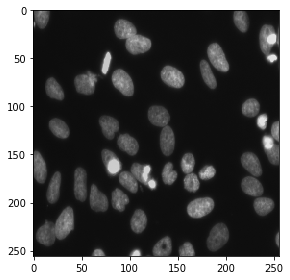

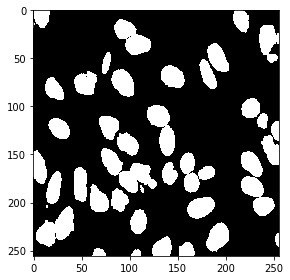

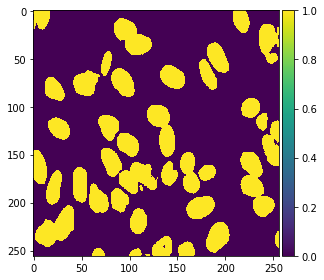

In [19]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

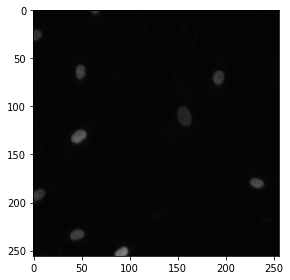

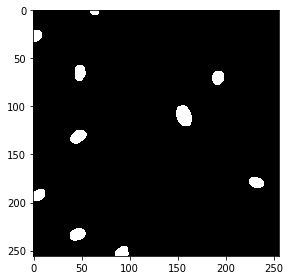

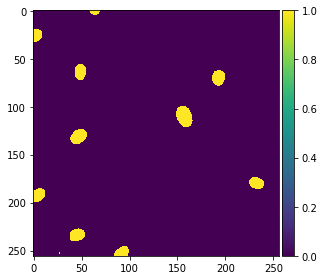

In [20]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [21]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [22]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [23]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-2-DA2-batch10.csv', index=False)